In [1]:
# enhance text display
!pip install rich
from rich import (print, inspect, pretty)
pretty.install()

In [2]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
## installs if required
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U einops
!pip install -q -U safetensors
!pip install -q -U torch
!pip install -q -U xformers
!pip install scipy

In [4]:
import time
t0 = time.time()

import warnings, logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [ ]:
!pip install transformers bitsandbytes
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Generating train split:   0%|          | 0/2043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/125 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/70 [00:00<?, ? examples/s]

image size:
(2481, 3508)

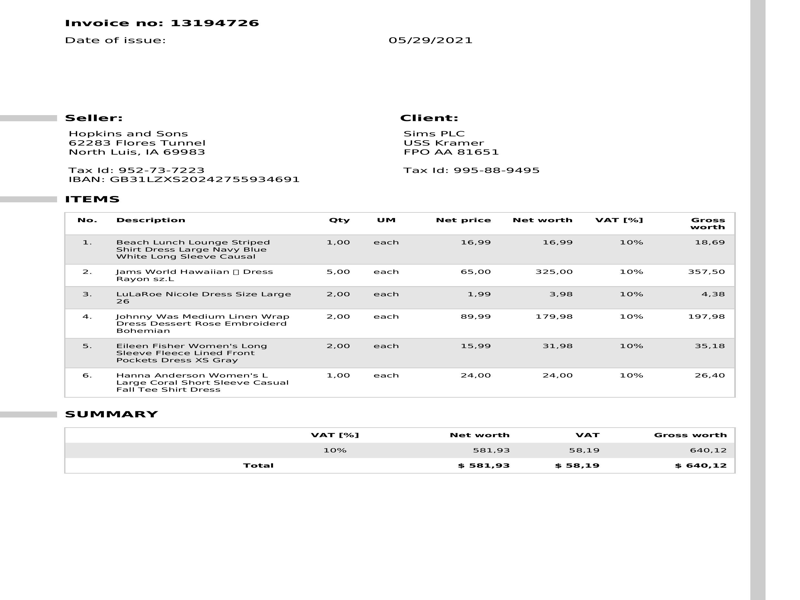

In [8]:
from datasets import load_dataset
dataset_id="mychen76/invoices-and-receipts_ocr_v1"
dataset = load_dataset(dataset_id)

def display_record(record):
    image1 = record['image']
    print("image size:", image1.size)
    display(image1.resize((800,600)))
    return image1

## pull a sample invoice image
input_image = display_record(dataset['test'][1])

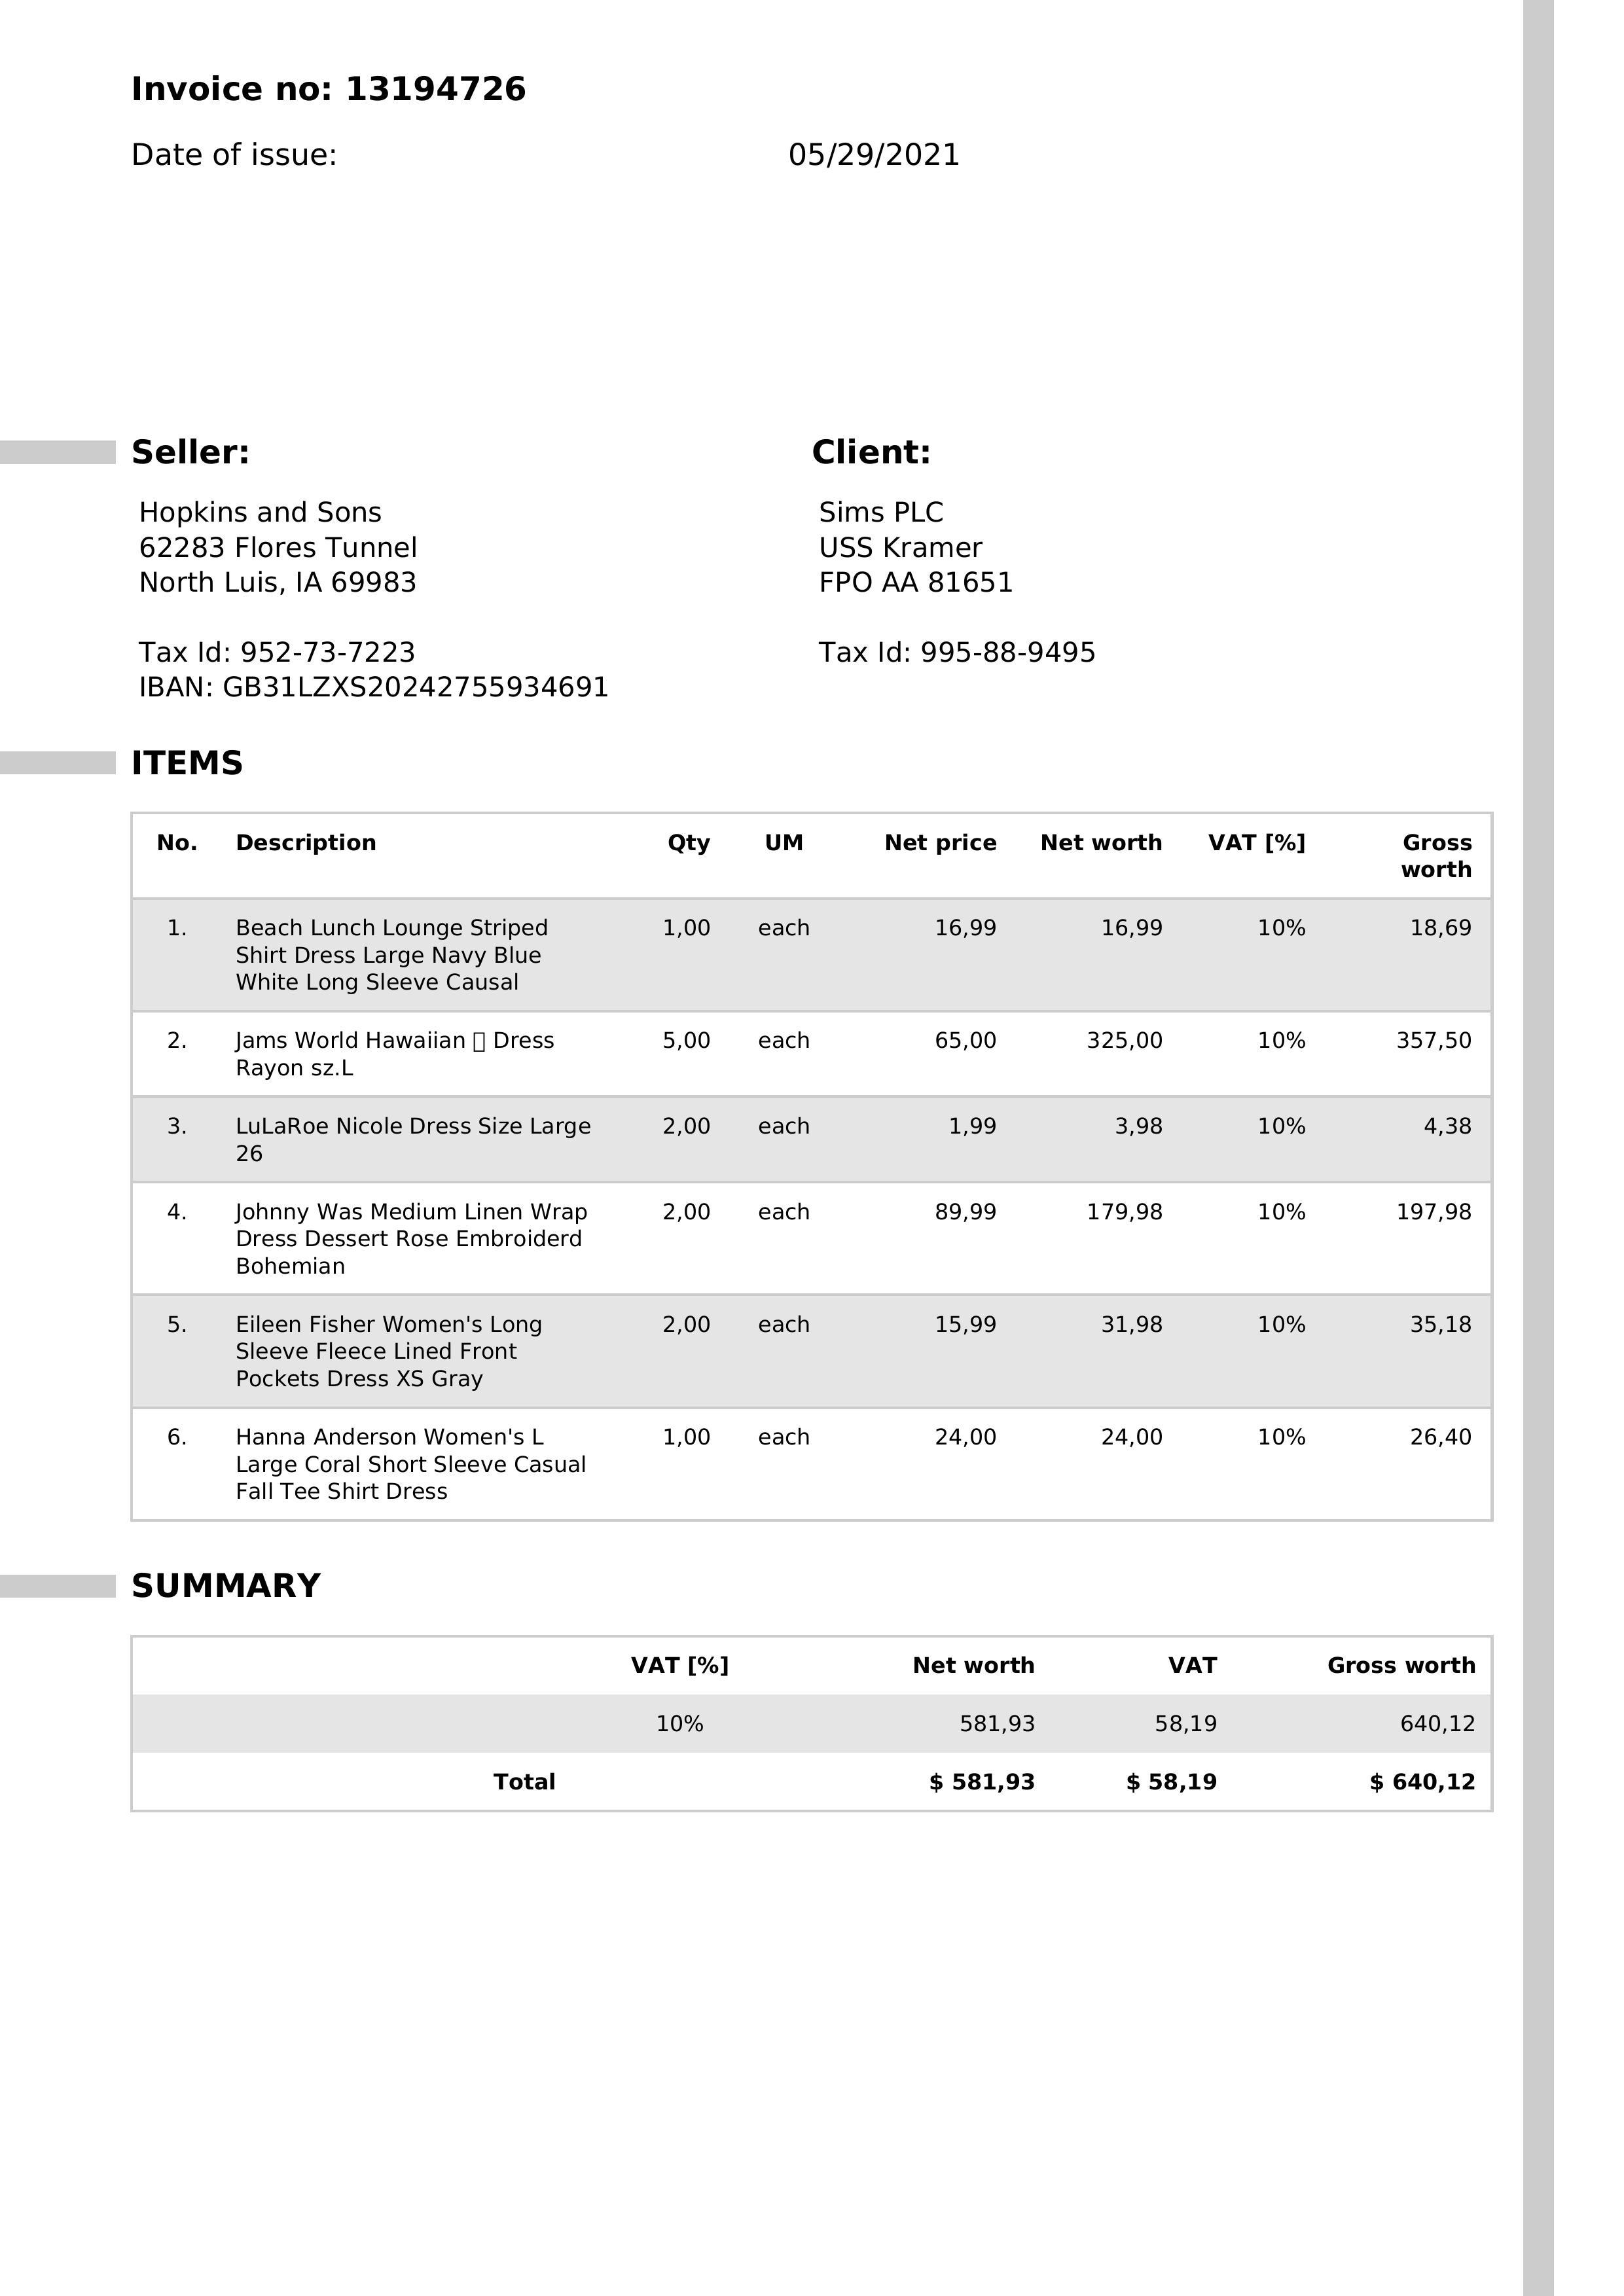

In [9]:
input_image

In [10]:
%%time
import torch
from transformers import DonutProcessor, VisionEncoderDecoderModel

model_id="mychen76/invoice-and-receipts_donut_v1"
def load_model(model_id=model_id):
    processor = DonutProcessor.from_pretrained(model_id)
    model = VisionEncoderDecoderModel.from_pretrained(model_id)
    return processor, model

processor, model = load_model(model_id)

preprocessor_config.json:   0%|          | 0.00/421 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/510 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.90k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/221 [00:00<?, ?B/s]

CPU times: user 17.6 s, sys: 5.57 s, total: 23.2 s
Wall time: 1min 25s


In [11]:
def generateTextInImage(processor,model,input_image,task_prompt="<s_receipt>"):
    pixel_values = processor(input_image, return_tensors="pt").pixel_values
    print ("input pixel_values: ",pixel_values.shape)
    task_prompt = "<s_receipt>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)
    return outputs

In [12]:
%%time
def generateOutputXML(processor,model, input_image, task_start="<s_receipt>",task_end="</s_receipt>"):
    import re
    outputs=generateTextInImage(processor,model,input_image,task_prompt=task_start)
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    return sequence

## generate xml
xml=generateOutputXML(processor,model,input_image)
print(xml)

input pixel_values: 
torch.Size([1, 3, 1280, 960])

<s_header><s_invoice_no> 13194726</s_invoice_no><s_invoice_date> 05/29/2021</s_invoice_date><s_seller> Hopkins and 
Sons 62283 Flores Tunnel North Luis, IA 69983</s_seller><s_client> Sims PLC USS Kramer FPO AA 
81651</s_client><s_seller_tax_id> 952-73-7223</s_seller_tax_id><s_client_tax_id> 
995-88-9495</s_client_tax_id><s_iban> GB31LZX520242755934691</s_iban></s_header><s_items><s_item_desc> Beach Lunch 
Lounge Striped Shirt Dress Large Navy Blue White Long Sleeve Casual</s_item_desc><s_item_qty> 
1,00</s_item_qty><s_item_net_price> 16,99</s_item_net_price><s_item_net_worth> 16,99</s_item_net_worth><s_item_vat>
10%</s_item_vat><s_item_gross_worth> 18,69</s_item_gross_worth><sep/><s_item_desc> Jams World Hawaiian 0 Dress 
Rayon SZ.L</s_item_desc><s_item_qty> 5,00</s_item_qty><s_item_net_price> 65,00</s_item_net_price><s_item_net_worth>
325,00</s_item_net_worth><s_item_vat> 10%</s_item_vat><s_item_gross_worth> 
357,50</s_item_gross_worth><sep/><s_item_desc> LuLaRoe Nicole Dress Size Large 26</s_item_desc><s_item_qty> 
2,00</s_item_qty><s_item_net_price> 1,99</s_item_net_price><s_item_net_worth> 3,98</s_item_net_worth><s_item_vat> 
10%</s_item_vat><s_item_gross_worth> 4,38</s_item_gross_worth><sep/><s_item_desc> phynny Was Medium Linen Wrap 
Dress Dessert Rose Embroidered Bohemian</s_item_desc><s_item_qty> 2,00</s_item_qty><s_item_net_price> 
89,99</s_item_net_price><s_item_net_worth> 179,98</s_item_net_worth><s_item_vat> 
10%</s_item_vat><s_item_gross_worth> 197,98</s_item_gross_worth><sep/><s_item_desc> Eileen Fisher Women's Long 
Sleeve Fleece Lined Front Pockets Dress XS Gray</s_item_desc><s_item_qty> 2,00</s_item_qty><s_item_net_price> 
15,99</s_item_net_price><s_item_net_worth> 31,98</s_item_net_worth><s_item_vat> 
10%</s_item_vat><s_item_gross_worth> 35,18</s_item_gross_worth><sep/><s_item_desc> Hanna Anderson Women's L Large 
Coral Short Sleeve Casual Fall Tee Shirt Dress</s_item_desc><s_item_qty> 1,00</s_item_qty><s_item_net_price> 
24,00</s_item_net_price><s_item_net_worth> 24,00</s_item_net_worth><s_item_vat> 
10%</s_item_vat><s_item_gross_worth> 26,40</s_item_gross_worth></s_items><s_summary><s_total_net_worth> 
$581,93</s_total_net_worth><s_total_vat> $58,19</s_total_vat><s_total_gross_worth> $ 
640,12</s_total_gross_worth></s_summary>

CPU times: user 36.8 s, sys: 5.57 s, total: 42.4 s
Wall time: 45.3 s


In [13]:
%%time
def convertOutputToJson(processor, xml):
    result=processor.token2json(sequence)
    print(":vampire:",result)
    return result

def generateOutputJson(processor,model, input_image, task_start="<s_receipt>",task_end="</s_receipt>"):
    xml = generateOutputXML(processor,model, input_image,task_start=task_start,task_end=task_end)
    result=processor.token2json(xml)
    print(":vampire:",result)
    return result

## generate json
invoice1_json=generateOutputJson(processor,model,input_image)
print(invoice1_json)

input pixel_values: 
torch.Size([1, 3, 1280, 960])

🧛
{
    'header': {
        'invoice_no': '13194726',
        'invoice_date': '05/29/2021',
        'seller': 'Hopkins and Sons 62283 Flores Tunnel North Luis, IA 69983',
        'client': 'Sims PLC USS Kramer FPO AA 81651',
        'seller_tax_id': '952-73-7223',
        'client_tax_id': '995-88-9495',
        'iban': 'GB31LZX520242755934691'
    },
    'items': [
        {
            'item_desc': 'Beach Lunch Lounge Striped Shirt Dress Large Navy Blue White Long Sleeve Casual',
            'item_qty': '1,00',
            'item_net_price': '16,99',
            'item_net_worth': '16,99',
            'item_vat': '10%',
            'item_gross_worth': '18,69'
        },
        {
            'item_desc': 'Jams World Hawaiian 0 Dress Rayon SZ.L',
            'item_qty': '5,00',
            'item_net_price': '65,00',
            'item_net_worth': '325,00',
            'item_vat': '10%',
            'item_gross_worth': '357,50'
        },
        {
            'item_desc': 'LuLaRoe Nicole Dress Size Large 26',
            'item_qty': '2,00',
            'item_net_price': '1,99',
            'item_net_worth': '3,98',
            'item_vat': '10%',
            'item_gross_worth': '4,38'
        },
        {
            'item_desc': 'phynny Was Medium Linen Wrap Dress Dessert Rose Embroidered Bohemian',
            'item_qty': '2,00',
            'item_net_price': '89,99',
            'item_net_worth': '179,98',
            'item_vat': '10%',
            'item_gross_worth': '197,98'
        },
        {
            'item_desc': "Eileen Fisher Women's Long Sleeve Fleece Lined Front Pockets Dress XS Gray",
            'item_qty': '2,00',
            'item_net_price': '15,99',
            'item_net_worth': '31,98',
            'item_vat': '10%',
            'item_gross_worth': '35,18'
        },
        {
            'item_desc': "Hanna Anderson Women's L Large Coral Short Sleeve Casual Fall Tee Shirt Dress",
            'item_qty': '1,00',
            'item_net_price': '24,00',
            'item_net_worth': '24,00',
            'item_vat': '10%',
            'item_gross_worth': '26,40'
        }
    ],
    'summary': {'total_net_worth': '$581,93', 'total_vat': '$58,19', 'total_gross_worth': '$ 640,12'}
}

{
    'header': {
        'invoice_no': '13194726',
        'invoice_date': '05/29/2021',
        'seller': 'Hopkins and Sons 62283 Flores Tunnel North Luis, IA 69983',
        'client': 'Sims PLC USS Kramer FPO AA 81651',
        'seller_tax_id': '952-73-7223',
        'client_tax_id': '995-88-9495',
        'iban': 'GB31LZX520242755934691'
    },
    'items': [
        {
            'item_desc': 'Beach Lunch Lounge Striped Shirt Dress Large Navy Blue White Long Sleeve Casual',
            'item_qty': '1,00',
            'item_net_price': '16,99',
            'item_net_worth': '16,99',
            'item_vat': '10%',
            'item_gross_worth': '18,69'
        },
        {
            'item_desc': 'Jams World Hawaiian 0 Dress Rayon SZ.L',
            'item_qty': '5,00',
            'item_net_price': '65,00',
            'item_net_worth': '325,00',
            'item_vat': '10%',
            'item_gross_worth': '357,50'
        },
        {
            'item_desc': 'LuLaRoe Nicole Dress Size Large 26',
            'item_qty': '2,00',
            'item_net_price': '1,99',
            'item_net_worth': '3,98',
            'item_vat': '10%',
            'item_gross_worth': '4,38'
        },
        {
            'item_desc': 'phynny Was Medium Linen Wrap Dress Dessert Rose Embroidered Bohemian',
            'item_qty': '2,00',
            'item_net_price': '89,99',
            'item_net_worth': '179,98',
            'item_vat': '10%',
            'item_gross_worth': '197,98'
        },
        {
            'item_desc': "Eileen Fisher Women's Long Sleeve Fleece Lined Front Pockets Dress XS Gray",
            'item_qty': '2,00',
            'item_net_price': '15,99',
            'item_net_worth': '31,98',
            'item_vat': '10%',
            'item_gross_worth': '35,18'
        },
        {
            'item_desc': "Hanna Anderson Women's L Large Coral Short Sleeve Casual Fall Tee Shirt Dress",
            'item_qty': '1,00',
            'item_net_price': '24,00',
            'item_net_worth': '24,00',
            'item_vat': '10%',
            'item_gross_worth': '26,40'
        }
    ],
    'summary': {'total_net_worth': '$581,93', 'total_vat': '$58,19', 'total_gross_worth': '$ 640,12'}
}

CPU times: user 35.7 s, sys: 3.61 s, total: 39.3 s
Wall time: 40.9 s
